# package_LAB

In [1]:
# Correct import statements and package reloads
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
from ipywidgets import interact, FloatSlider,Layout
import package_DBR

import package_LAB

from importlib import reload
package_LAB = reload(package_LAB)
from package_DBR import myRound, SelectPath_RT, Delay_RT,Process,Bode
from package_LAB import LL_RT,PID_RT, IMCTuning, PID,Margin



# LL_RT()

In [2]:
help(LL_RT)

Help on function LL_RT in module package_LAB:

LL_RT(MV, Kp, Ts, Tle, Tla, PV, PVInit=0, method='EBD')
    The function "LL_RT" needs to be included in a "for or while loop".
    
    :MV: input vector
    :Kp: process gain
    :Tla: lag time constant [s]
    :Ts: sampling period [s]
    :Tle: lead time constant [s]
    :PV: output vector
    :PVInit: (optional: default value is 0)
    :method: discretisation method (optional: default value is 'EBD')
        EBD: Euler Backward difference
        EFD: Euler Forward difference
        TRAP: Trapezoïdal method
    
    The function "LL_RT" appends a value to the output vector "PV".
    The appended value is obtained from a recurrent equation that depends on the discretisation method.



(0.0, 100.0)

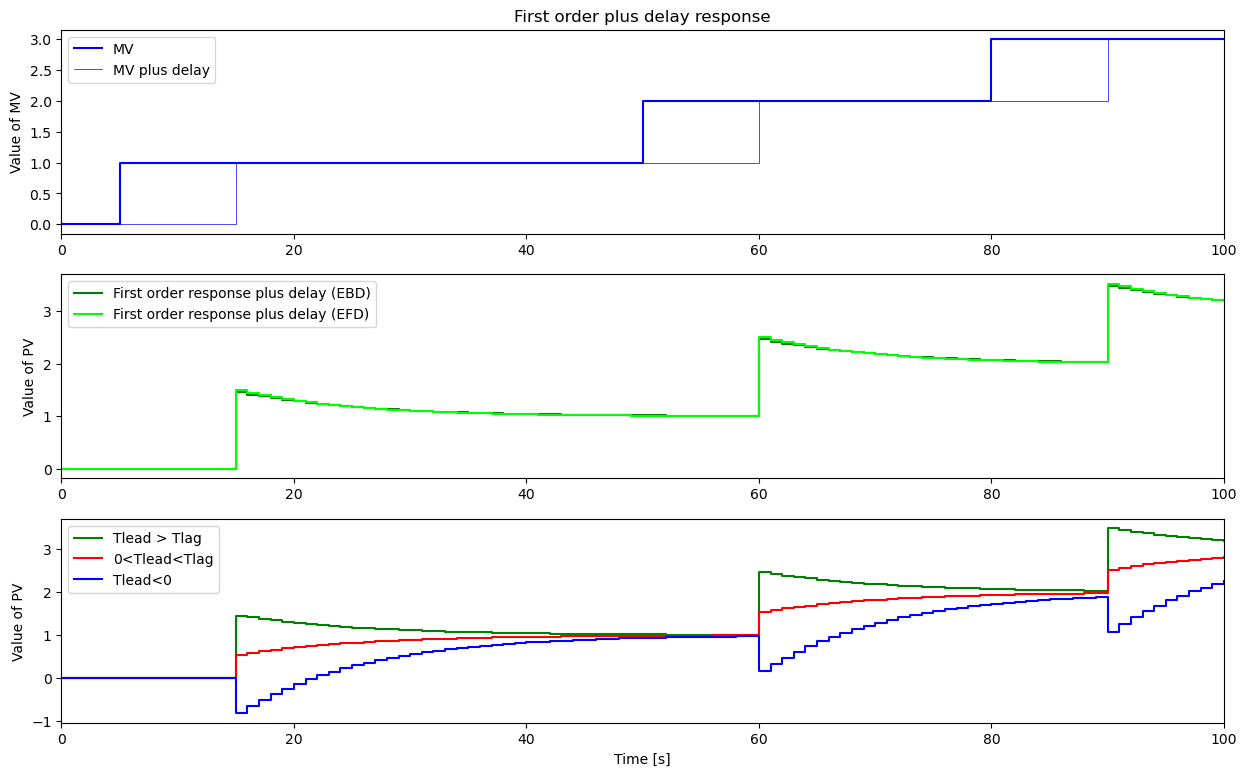

In [18]:
# Simulation parameters
TSim = 100
Ts = 1
N = int(TSim/Ts) + 1

# Path for MV
MVPath = {0: 0, 5: 1, 50: 2, 80: 3, TSim: 3}

# Initializing vectors
t = []
MV = []
MVDelay = []
PV_EBD = []
PV_EFD = []
PV_TRAP = []
PV_Tle1 = []
PV_Tle2 = []
PV_Tle3 = []

# Parameters
Kp = 1
Tla1 = 10
Tle1 = 15
Tle2 = 5
Tle3 = -10

theta = 10

# Main loop
for i in range(0, N):
    t.append(i*Ts)
    SelectPath_RT(MVPath, t, MV)
    Delay_RT(MV, theta, Ts, MVDelay)
    LL_RT(MVDelay, Kp, Ts, Tle, Tla, PV_EBD, 0, 'EBD')
    LL_RT(MVDelay, Kp, Ts, Tle, Tla, PV_EFD, 0, 'EFD')
    LL_RT(MVDelay, Kp, Ts, Tle1, Tla, PV_Tle1, 0, 'EBD')
    LL_RT(MVDelay, Kp, Ts, Tle2, Tla, PV_Tle2, 0, 'EBD')
    LL_RT(MVDelay, Kp, Ts, Tle3, Tla, PV_Tle3, 0, 'EBD')
    # LL_RT(MVDelay, Kp, Ts, Tle, Tla, T, PV_TRAP, 0, 'TRAP')

# Plotting results
plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)
plt.step(t, MV, 'b-', label='MV', where='post')
plt.step(t, MVDelay, 'b-', linewidth=0.5, label='MV plus delay', where='post')
plt.ylabel('Value of MV')
plt.title('First order plus delay response')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(3, 1, 2)
plt.step(t, PV_EBD, 'g-', label='First order response plus delay (EBD)', where='post')
plt.step(t, PV_EFD, 'lime', label='First order response plus delay (EFD)', where='post')
# plt.step(t, PV_TRAP, 'springgreen', label='First order response plus delay (TRAP)', where='post')
plt.ylabel('Value of PV')

plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(3, 1, 3)
plt.step(t, PV_Tle1, 'g-', label='Tlead > Tlag', where='post')
plt.step(t, PV_Tle2, 'r-', label='0<Tlead<Tlag', where='post')
plt.step(t, PV_Tle3, 'b-', label='Tlead<0', where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])

# PID_RT

In [4]:
help(PID_RT)

Help on function PID_RT in module package_LAB:

PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVmin, MVmax, MV, MVP, MVI, MVD, E, ManFF=False, PVinit=0, method='EBD-EBD')
    SP = setpoint vector
    PV = process value vector
    Man = manual controller mode vector : bool
    MVMan = Manual value for MV vector
    MVFF = feedforward vector
    Kc = controller gain
    Ti= integral time constant
    Td = derivative time constant
    alpha = Tfd = alpha*Td = where Tfd is derivative filter time constant
    
    MVMin = min value for MV
    MVMax = max value for MV
    
    MV = Maniplated value vector
    MVP = proportional part of MV vector
    MVI =  integral part of MV vector
    MVD = derivative part of MV vector
    E = control error vector
    
    ManFF = activated FF in manuel mode
    PVInit = initial value of PV
    Method : discreditisation value for PV
        EBD-EBD: Euler Backward difference
        TRAP-TRAP: Trapezoïdal method
    
    The function PID_RT appen

In [23]:
# Initialize
t = []
TSim = 1200
Ts = 0.01
N = int(TSim/Ts) + 1
PVInit = 0
MVmin = 0
MVmax = 100
ManStart = 600
ManEnd = 700

SP = []
MV = []
PV = []
DV =[]
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = [] 
E  = []

# Paths
MVManPath = {0: 50, TSim: 50}  #Valeur MV en mode manuel jusqu'à valeur max de temps TSim
SPPath = {0: 50, 50: 60, TSim: 60}
PVPath = {0: 50, 50: 50, TSim: 50}
ManPath = {0: False, ManStart: True, ManEnd: False, TSim: False} #Timing du passage en mode manuel
MVFFPath = {0: 0, 1100 :60, TSim: 60}

# Parameters
Kc = 1
Ti = 50
Td = 5
alpha = 0.6

def update_plot(Kc, Ti, Td, alpha, TSim, ManStart,ManEnd):
    t.clear()
    SP.clear()
    PV.clear()
    Man.clear()
    MVMan.clear()
    MVFF.clear()
    MV.clear()
    MVP.clear()
    MVI.clear()
    MVD.clear()
    E.clear()
    # Update ManPath with new ManStart and ManEnd values from sliders
    ManPath = {0: False, ManStart: True, ManEnd: False, TSim: False}
    
    for i in range(0, N):
        t.append(i * Ts)
        SelectPath_RT(SPPath, t, SP)
        SelectPath_RT(PVPath, t, PV)
        SelectPath_RT(ManPath, t, Man)
        SelectPath_RT(MVManPath, t, MVMan)
        SelectPath_RT(MVFFPath, t, MVFF)
        
        PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVmin, MVmax, MV, MVP, MVI, MVD, E, False, PVInit, "EBD-EBD")
    
    
    # Plot MV  
    plt.figure(figsize=(15, 15))
    plt.subplot(4, 1, 1)
    plt.step(t, MV, 'b-', label='MV', where='post')
    plt.step(t, MVP, '--y', label='MVP', where='post')
    plt.step(t, MVI, '--c', label='MVI', where='post')
    plt.step(t, MVD, '--r', label='MVD', where='post')
    plt.step(t, MVFF, '--g', label='MVFF', where='post')
    plt.step(t, E, 'k-', linewidth=1, label='E', where='post')
    plt.ylabel('Value of MV')
    plt.title('PID response')
    plt.legend(loc='upper right')
    plt.xlim([0, TSim])
    
    # Plot Man
    plt.subplot(4, 1, 2)
    plt.step(t, Man, 'b-', linewidth=1, label='Man', where='post')
    plt.ylabel('Value of Man')
    plt.legend(loc='best')
    plt.xlim([0, TSim])
    
#sliders
Kc_slider = FloatSlider(value=Kc, min=0.1, max=5.0, step=0.1, description='Kc:', layout=Layout(width='50%'))
Ti_slider = FloatSlider(value=Ti, min=0.1, max=100.0, step=0.1, description='Ti:', layout=Layout(width='50%'))
Td_slider = FloatSlider(value=Td, min=1, max=20, step=1, description='Td:', layout=Layout(width='50%'))
alpha_slider = FloatSlider(value=alpha, min=0.1, max=1.0, step=0.1, description='Alpha:', layout=Layout(width='50%'))
ManStart_slider = FloatSlider(value=ManStart, min=100, max=2000, step=100, description='ManStart:', layout=Layout(width='50%'))
ManEnd_slider = FloatSlider(value=ManEnd, min=100, max=2000, step=100, description='ManEnd:', layout=Layout(width='50%'))
TSim_slider = FloatSlider(value=TSim, min=100, max=2000, step=100, description='TSim:', layout=Layout(width='50%'))

interact(update_plot, Kc=Kc_slider, Ti=Ti_slider, Td=Td_slider, alpha=alpha_slider, TSim = TSim_slider, ManStart = ManStart_slider, ManEnd = ManEnd_slider)


interactive(children=(FloatSlider(value=1.0, description='Kc:', layout=Layout(width='50%'), max=5.0, min=0.1),…

<function __main__.update_plot(Kc, Ti, Td, alpha, TSim, ManStart, ManEnd)>

# IMCTuning()

In [6]:
help(IMCTuning)

Help on function IMCTuning in module package_LAB:

IMCTuning(K, Tlag1, Tlag2=0, theta=0, gamma=0.5, process='FOPDT-PI')
    IMCTuning computes the IMC PID tuning parameters for FOPDT and SOPDT processes.
    K: process gain (Kp)
    Tlag1: first (main) lag time constant [s]
    Tlag2: second lag time constant [s]
    theta: delay [s]
    gamma: used to computed the desired closed loop time constant Tclp [s] (range [0.2 -> 0.9])
    process:
        FOPDT-PI: First Order Plus Dead Time for P-I control (IMC tuning case G)
        FOPDT-PID: First Order Plus Dead Time for P-I-D control (IMC tuning case H)
        SOPDT :Second Order Plus Dead Time for P-I-D control (IMC tuning case I)
        
    return : PID controller parameters Kc, Ti and Td



In [7]:
# Parameters for input-output dynamic
Kp = 0.48
T1p = 160
T2p = 11
thetap = 4

# Parameters PID controller
gamma = 0.8                                # A faire : Discuter variation de gamma
Kc, Ti, Td = IMCTuning(Kp,T1p,T2p,thetap,gamma, 'SOPDT')

print("Kc = ",Kc)
print("Ti = ",Ti)
print("Td = ",Td)

Kc =  2.6988636363636362
Ti =  171
Td =  10.292397660818713


# Margin()

In [8]:
help(Margin)

Help on function Margin in module package_LAB:

Margin(Ps, C, omega, Show=True)
    Calculate the gain margin and phase margin. They allow us to analyze the robustness of the PID.
    :Ps : Process
    :C: Controller Transfer Function
    :omega : frequency vector
    :show : allows graphical display



Gain margin : 29.99250355051349 dB at the ultimate frequency : 0.19981590898062868 rad/s
Phase margin :  88.53391401556208 ° at the crossover frequency : 0.006737252873212744 rad/s
Kc =  2.3980501680564545


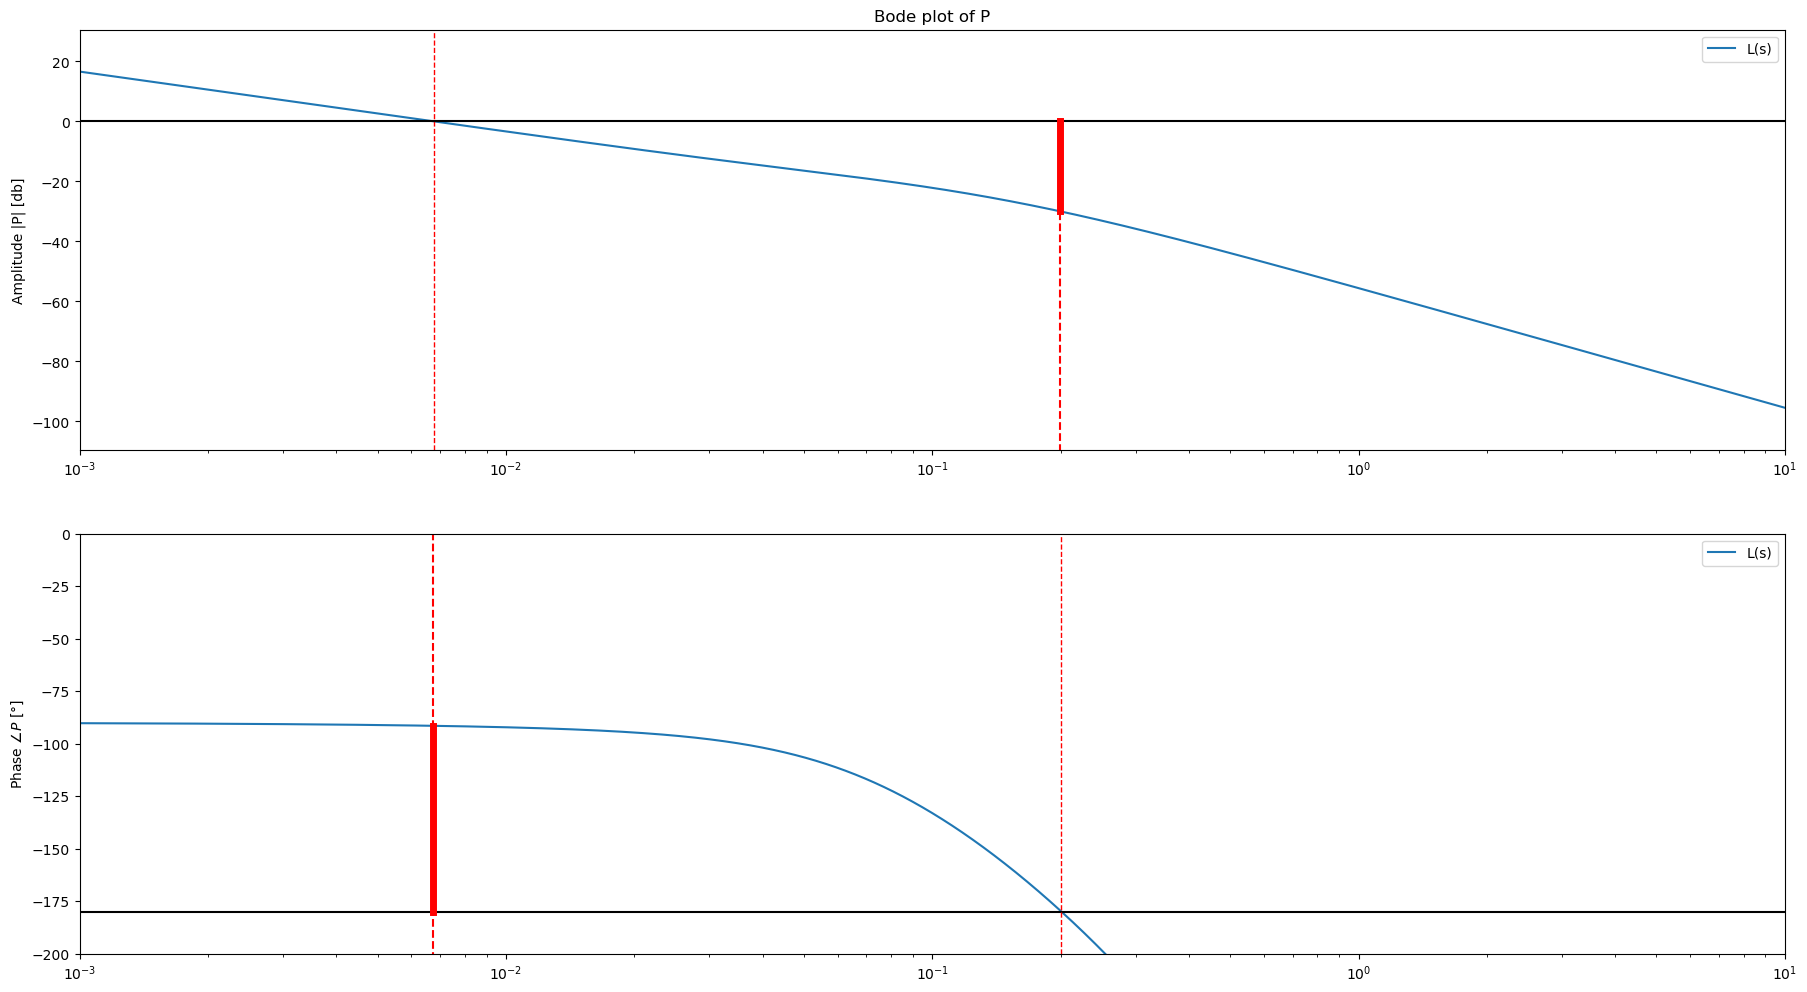

In [39]:
P = Process({})

Kp = 0.48305278277951064
T1p = 159.84828454194727
T2p = 11.44559902845228
thetap = 4.009584499836511
gamma = 0.9

P.parameters['Kp'] = Kp
P.parameters['Tlag1'] = T1p
P.parameters['Tlag2'] = T2p
P.parameters['theta'] = thetap

Kc, Ti, Td = IMCTuning(Kp,T1p,T2p,thetap,gamma, 'SOPDT')

C = PID({})
C.parameters['Kc'] = Kc
C.parameters['Ti'] = Ti
C.parameters['Td']= Td
C.parameters['Tfd'] = alpha *Td # temps dérivation après filtrage


omega = np.logspace(-3,1,10000)

Ps = Bode(P,omega,Show=False)

Margin(Ps,C,omega)
print("Kc = ",Kc)